In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

In [5]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [6]:
NoOfPeakSeason = 2
lengthPeakSeason = 24
NoOfRegSeason = 4
lengthRegSeason = 24
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['GasCCGT',    'GasOCGT',  'Bio',   'Oilexisting',  'Windonshore',  'Solar'  ,'Hydrorun-of-the-river', 'Hydroregulated', 'Geo']
scenario = '1'
date = '0422'
time = '1632'
file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_Operational.csv')

In [7]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df


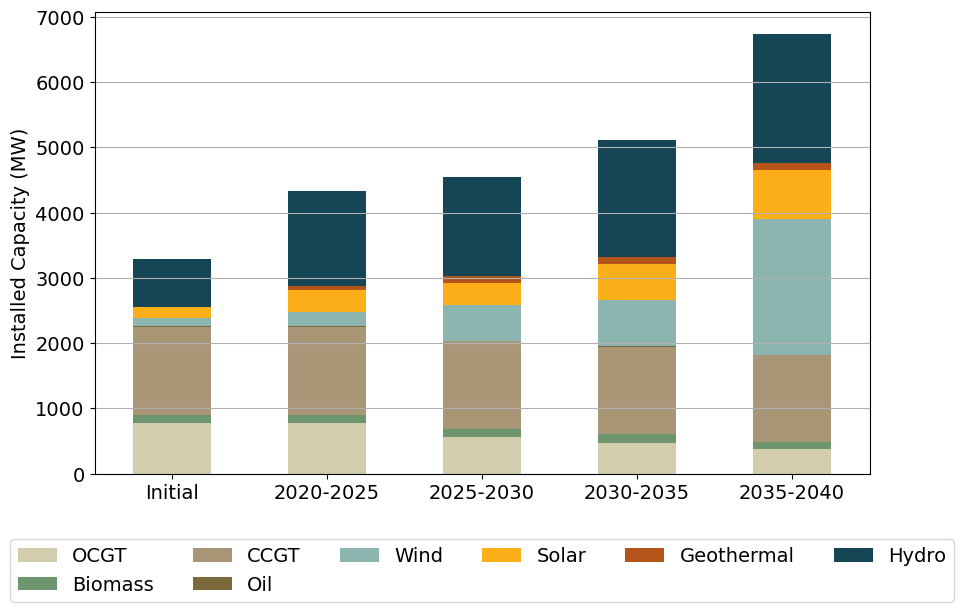

In [8]:
included_rows = [2,3,4,5,6]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

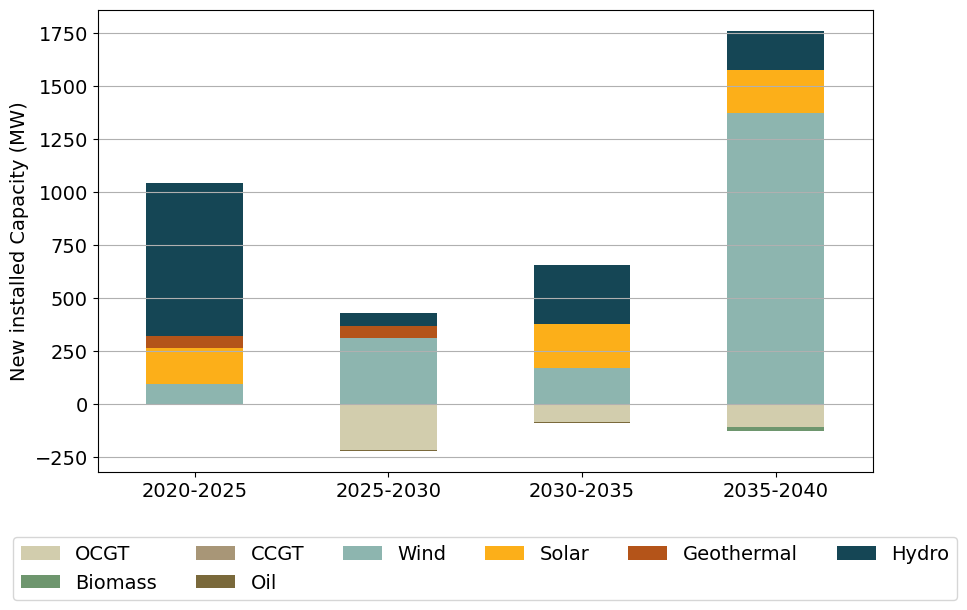

In [15]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

plt.ylabel('New installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
#plt.ylim(0, 1000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

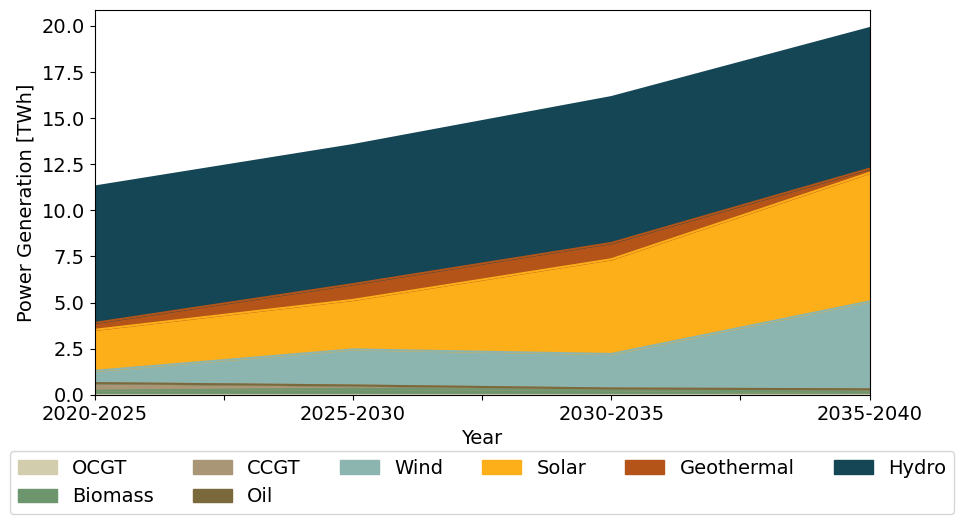

In [10]:
included_rows = [10,11,12,13]

dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)
dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5))
production_plot.set_xlim(0,3)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/Production.png', bbox_inches='tight')

C:\Users\noraky\AppData\Local\Temp\ipykernel_12512\3468604225.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


(1.0, 80.0)

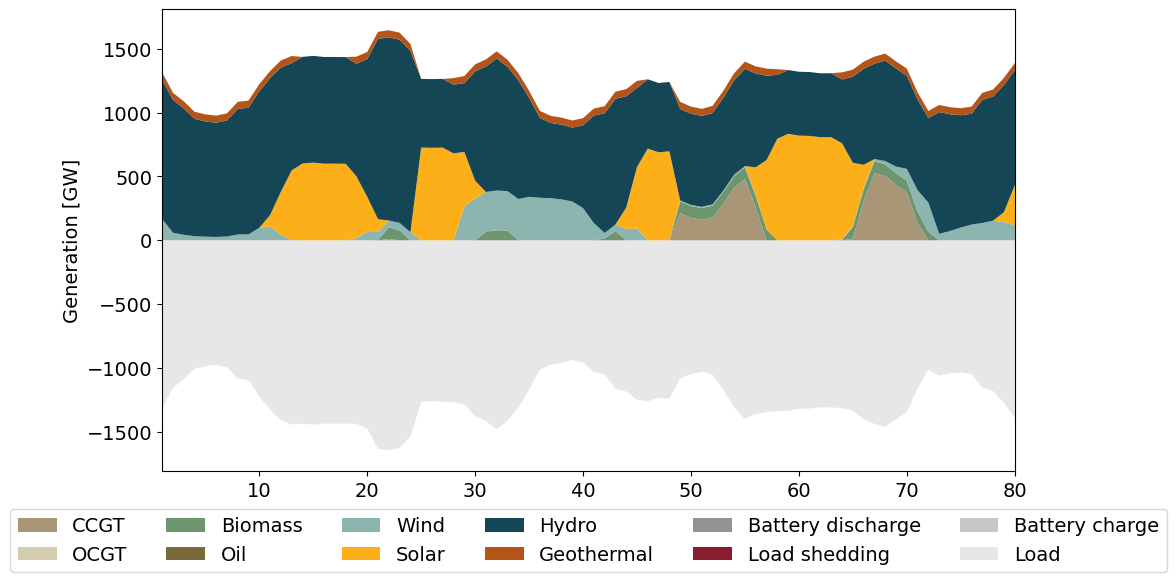

In [12]:
period = '2020-2025'
regular_seasons = ['winter', 'spring', 'summer', 'fall']

filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons))]
snapshot_columns = [tech + '_MW' for tech in old_names]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1])
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(1, 80)
plt.savefig('figures/Dispatch.png', bbox_inches='tight')